# Create file with coefficients needed for air-sea gas exchange

In [3]:
# standard imports
import os
import numpy as np
import pandas as pd
import xarray as xr
import datetime
import matplotlib.dates as mdates
import glob

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots
%matplotlib inline

In [5]:
%run _Val_Mapping.ipynb

In [6]:
%run co2_flux_equations.ipynb

ERROR:root:File `'co2_flux_equations.ipynb.py'` not found.


In [3]:
gcb_corr_dir = "/data/artemis/workspace/vbennington/LDEO_HPD/models/XGB/clim_corrected/2000_2018_clim"

models = ['cesm','csiro','fesom','mpi','cnrm','ipsl','planktom','noresm','princeton']
models3 = ['csiro','noresm','princeton']

In [4]:
ds = xr.merge([xr.open_dataset(fl) for fl in glob.glob(f'{gcb_corr_dir}/*_clim_corrected_gcbA2020.nc')],compat='override')

# make dummy variable of zeros
ds['spco2'] = ds['cesm_corrected_spco2']*0
ds['spco2_3mods'] = ds['cesm_corrected_spco2']*0

# add all predictions together
for var in models:
    ds['spco2'] += ds[f'{var}_corrected_spco2']
# divide by number vars to average
ds['spco2'] = ds['spco2'] / len(models)

for var in models3:
    ds['spco2_3mods'] += ds[f'{var}_corrected_spco2']
# divide by number vars to average
ds['spco2_3mods'] = ds['spco2_3mods'] / len(models3)   

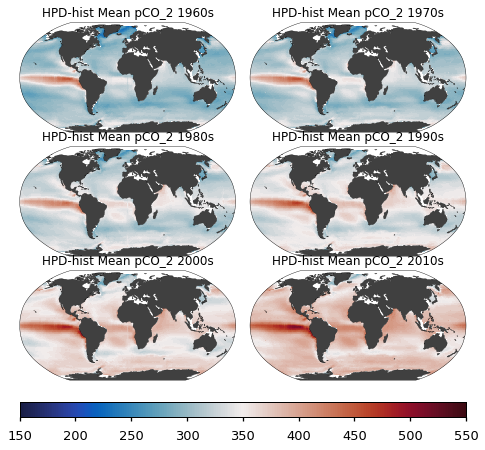

In [5]:
region='world'

cmap = cm.cm.balance
plot_style = 'seaborn-talk'

decades = ["1960","1970","1980","1990","2000","2010","2020"]
fig = plt.figure(figsize=(8,12))
fig_shape=(3,2)
vrange = [150, 550, 25]

with plt.style.context(plot_style):
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')   
    
    for d in range(6):

        data2 = ds.spco2.sel(time=slice(f'{decades[d]}-01-01',f'{decades[d+1]}-01-01')).mean("time")

        #data2 = xr_add_cyclic_point(data2, cyclic_coord='lon')    
        sub = dia.add_plot(lon=data2['lon'], lat=data2['lat'], data=data2, vrange=vrange[0:2], cmap=cmap, ax=d)
        dia.set_title(f"HPD-hist Mean pCO_2 {decades[d]}s",d,fontsize=12)
        col = dia.add_colorbar(sub)
        dia.set_cbar_xlabel(col,"",fontsize=10)

In [7]:
# Examine global mean spco2 by year:
global_spco2 = ds.spco2.mean(['lon','lat'])
global_spco2_3mod = ds.spco2_3mods.mean(['lon','lat'])

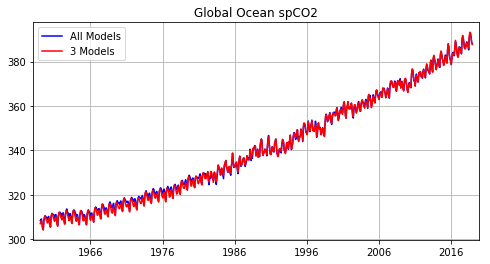

In [8]:
# Examine whether this is much difference between using
# ALL GCMs mean
# or 3 GCMs mean

figure = plt.figure(figsize=(8,4))
plt.plot(global_spco2.time,global_spco2,'blue',label="All Models")
plt.plot(global_spco2.time,global_spco2_3mod,'red',label="3 Models")
plt.grid(True)
plt.xlim(min(global_spco2.time.values),max(global_spco2.time.values))
plt.title("Global Ocean spCO2")
plt.legend()

# Coastal Filling

In [9]:
# HPD-Clim with coastal filling
coast_out=xr.open_dataset('/data/artemis/workspace/vbennington/LDEO_HPD/data_for_flux/coastal_scaling_map_centered_2006.nc')

hpd_filled = ds['spco2'].sel(time=slice("01-01-1959","12-31-2020")).fillna(coast_out.spco2_scale_clim)

Text(0.5,1,'Fill')

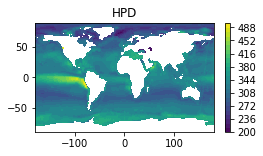

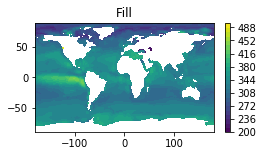

In [24]:
fig = plt.figure(figsize=(4,2))
plt.contourf(hpd_filled.lon,hpd_filled.lat,hpd_filled[200,:,:],levels=np.linspace(200,500,26))
plt.colorbar()
plt.title("HPD")
fig = plt.figure(figsize=(4,2))
plt.contourf(hpd_filled.lon,hpd_filled.lat,coast_out.spco2_scale_clim[200,:,:],levels=np.linspace(200,500,26))
plt.colorbar()
plt.title("Fill")

# Create Files of K0, Kw, and atmospheric pCO2 to be used each time

# with NOAA SST (1959-2019)

In [21]:
hpd_filled=hpd_filled.sel(time=slice("01-01-1959","12-31-2019"))

# SST from NOAA OI SST V2 (Dec 1981 - Aug 2019)
#NSST = xr.open_dataset("/data/artemis/workspace/vbennington/NOAA_SST/processed/NOAA_OISSTv2_1x1_mon_121981-072021.nc")
NSST = xr.open_dataset("/data/artemis/observations/NOAA_ERSST/NOAA_ERSST_1x1_mon_Jan1854-Feb2020.nc")
nsst = NSST.sst.sel(time=slice("01-01-1959","12-31-2019"))
nsst_C = np.where(np.isnan(hpd_filled),np.nan,nsst)

# Use hpd_filled to know where to put NaNs:

# SSS from E4.2.1 (Jan 1958 - Nov 2020)
sss = xr.open_dataset(f"/data/artemis/workspace/vbennington/EN421_salinity/processed/sss_1x1_mon_EN421_195801-202011.nc").sss
salt_bulk = sss.sel(time=slice("01-01-1959","12-31-2019"))
salt_bulk = np.where(np.isnan(hpd_filled),np.nan,salt_bulk)

# SST from Hadley (Jan 1870 - May 2021 )  -- ## 
########################################################################################
SST = xr.open_dataset("/data/artemis/observations/HadiICE/originals/HadISST_sst.nc")
SST = SST.rename({'latitude':'lat','longitude':'lon'})
# Latitude is upside down here; reorder:
# Sort by latitude
SST = SST.sortby('lat')
sst = SST.sst.sel(time=slice("01-01-1959","12-31-2019"))
sst_C = np.where(np.isnan(hpd_filled),np.nan,sst)

# SST from ERA5 (Jan 1958-July 2021)
ESST = xr.open_dataset("/data/artemis/observations/ERA5/processed/ERA5_SST_1x1_mon_1958-2021.nc")
esst = ESST.sst.sel(time=slice("01-01-1959","12-31-2019"))
esst_C = np.where(np.isnan(hpd_filled),np.nan,esst)


# Ice from Hadley (Jan 1870 - May 2021 )
ice = xr.open_dataset("/data/artemis/observations/HadiICE/originals/HadISST_ice.nc")
ice = ice.rename({'latitude':'lat','longitude':'lon'})
ice = ice.sortby('lat')
ice = ice.sel(time=slice("01-01-1959","12-31-2019"))
ice_frac = np.where(np.isnan(hpd_filled),np.nan,ice.sic)

# Wind and MSLP from ERA5:
era5 = xr.open_dataset('/data/artemis/observations/ERA5/processed/ERA5_MSLP_WS10_1x1_mon_1958-2020.nc')
era5 = era5.sel(time=slice("01-01-1959","12-31-2019"))
mslp = era5.mslp / 100 # Pascals to hPa
wind = era5.ws10
wsf = xr.open_dataset('/data/artemis/observations/ERA5/processed/ERA5_WS_STD_1x1_mon_1958-2019.nc')
wind_std = wsf.ws_std.sel(time=slice("01-01-1959","12-31-2019"))
press_hPa = np.where(np.isnan(hpd_filled),np.nan,mslp)
wind_ms = np.where(np.isnan(hpd_filled),np.nan,wind)
wind_std = np.where(np.isnan(hpd_filled),np.nan,wind_std)

# Atmospheric pCO2:
atmos = xr.open_dataset('/data/artemis/observations/ESRL/global_pco2_1959-2019.nc')
pCO2_air_uatm = atmos.pco2.sel(time=slice("01-01-1959","12-31-2019"))
mauna_pCO2_air_uatm = atmos.mauna_loa_pco2.sel(time=slice("01-01-1959","12-31-2019"))


# CarboScope atm pCO2
cs = xr.open_dataset('/data/artemis/simulations/CarboScope/CarboScope_global_atm_pco2_1x1_1957-2020.nc')
pCO2_air_cs = cs.pco2.sel(time=slice("01-01-1959","12-31-2019"))


In [14]:
kw_nsst = calc_kw_noice(wind_ms, wind_std, nsst_C) #units of cm/hr

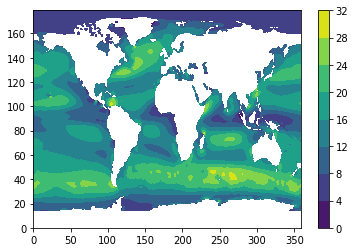

In [15]:
fig = plt.figure()
plt.contourf(kw_nsst.mean(axis=0))
plt.colorbar()

In [16]:
K0blk = calc_k0_weiss1974(salt_bulk, nsst_C+273.15, press_hPa/1013.25)  # units of mol/L/atm

In [17]:
print(np.nanmean(K0blk))

0.04536767588195549


In [18]:
print(np.nanmean(kw_nsst[-12*25::,:,:]))

15.040512574702296


In [23]:
# Create DataSet that can be used for all flux calculations!

date_range_start = f'1959-01-01T00:00:00.000000000'
date_range_end = f'2020-12-31T00:00:00.000000000'
# create date vector
dates = pd.date_range(start=date_range_start,end=date_range_end,freq='MS') + np.timedelta64(14, 'D')


ds_flux_prep = xr.Dataset({'K0':(['time','lat','lon'],K0blk),
                           'kw':(['time','lat','lon'],kw_nsst),
                           'ws10':(['time','lat','lon'],wind_ms),
                           'ws10_std':(['time','lat','lon'],wind_std),
                           'sss':(['time','lat','lon'],salt_bulk),
                           'sst':(['time','lat','lon'],esst_C),
                           'ice':(['time','lat','lon'],ice_frac),
                           'slp':(['time','lat','lon'],press_hPa/1013.25),
                           'atmos_pco2':(['time','lat','lon'],pCO2_air_uatm),
                           'mauna_pco2':(['time','lat','lon'],mauna_pCO2_air_uatm),
                           'carbo_scope_pco2':(['time','lat','lon'],pCO2_air_cs),
                           'time':(['time'],dates),
                           'lat':(['lat'],ds.lat),
                           'lon':(['lon'],ds.lon)})

ds_flux_prep['K0'].attrs['units'] = "mol/L/atm"
ds_flux_prep['kw'].attrs['units'] = "cm/hr"
ds_flux_prep['atmos_pco2'].attrs['units'] = "mu atm"
ds_flux_prep['mauna_pco2'].attrs['units'] = "mu atm"
ds_flux_prep['carbo_scope_pco2'].attrs['units'] = "mu atm"
ds_flux_prep['kw'].attrs['more_info'] = "ice fraction not used here for kw calculation"
ds_flux_prep['sst'].attrs['units'] = "deg C (NOAA ERSST)"
ds_flux_prep['ws10'].attrs['units'] = "m/s (ERA5)"
ds_flux_prep['slp'].attrs['units'] = "atmospheres"
ds_flux_prep.attrs['more_info'] = "ERA5 for wind, MSLP; SST, Hadley Ice; E4.2.1 for SSS"
    
ds_flux_prep.to_netcdf("/data/artemis/workspace/vbennington/LDEO_HPD/data_for_flux/NOAA_ERSST_K0_kw_atmos_pco2_1959-2020.nc")

In [7]:
def calc_kw_noice(wind_speed, wind_std, temp_C):
    # wind in m/s, SST in Celsius
    
    from numpy import array 
    
    Uavg = array(wind_speed)
    Ustd = array(wind_std)
    T = array(temp_C)
    Uavg2 = Uavg ** 2
    U2 = Uavg2 + (Ustd ** 2)
    
    #Sc = schmidt_number(T)
    aSc = +2116.8
    b = -136.25
    c = +4.7353
    d = -0.092307
    eSc = +0.0007555
    Sc = aSc + b * T + c * T ** 2 + d * T ** 3 + eSc * T ** 4
    
    Sc660 = (Sc / 660) ** -0.5
    
    #a = 0.276 #for ERA5 # ERA5 from Gregor, Fay SeaFlux Package = 0.276 (2020)
    a = 0.270875 # updated 2021 number from Amanda and latest SeaFlux file
    
    kw = a * U2 * Sc660
    
    return kw   #cm/hr